In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install -r https://raw.githubusercontent.com/abbbe/eye-on-stick/main/requirements.txt
    !git clone https://github.com/abbbe/eye-on-stick
    %cd eye-on-stick

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

import os, urllib
import mlflow, git

from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.vec_env import VecNormalize
from stable_baselines import PPO2, SAC

import matplotlib.pyplot as plt
%matplotlib inline

from lib import eos
from lib.eos import EyeOnStickEnv

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
from PIL import Image, ImageDraw
from IPython import display
from io import BytesIO

def showarray(img_array):
    buf = BytesIO()
    Image.fromarray(np.uint8(img_array)).save(buf, 'png')
    display.display(display.Image(data=buf.getvalue()))

In [4]:
#assert not git.Repo().is_dirty()

In [5]:
# we run N_ERAS eras (=mlflow runs), each era consists of N_STEPS steps
# at the end of each era we report metrics to mlflow and learn for N_LEARN_EPOCHS epochs
N_ERAS = 25 # eras 
N_STEPS = 1000 # steps each
N_LEARN_EPOCHS = 10000

N_ENVS = 1

In [6]:
def run(N_JOINTS, N_SEGS, POLICY_CLASS, MODEL_NAME, N_ENVS=N_ENVS):
    env = make_vec_env(lambda: EyeOnStickEnv(N_JOINTS, N_SEGS), n_envs=N_ENVS)
    env = VecNormalize(env)
    
    run_name = f'{N_JOINTS}J{N_SEGS}S'

    with mlflow.start_run(run_name=run_name) as parent_run:
        mlflow_artifacts_dir = urllib.request.url2pathname(urllib.parse.urlparse(mlflow.get_artifact_uri()).path)

        mlflow.log_param("policy_class", POLICY_CLASS.__name__)
        mlflow.log_param("model_name", MODEL_NAME)

        tensorboard_logdir = os.path.join(mlflow_artifacts_dir, "tensorboard_log")
        os.makedirs(tensorboard_logdir, exist_ok=False)

        model = POLICY_CLASS(MODEL_NAME, env, verbose=1, tensorboard_log=tensorboard_logdir)

        for era in range(N_ERAS):
            with mlflow.start_run(run_name=f'era={era}', nested=True) as child_run:
                all_alphas, all_rewards = [], []

                obs = env.reset()

                for _ in range(N_STEPS):
                    display.clear_output(wait=True)
                    showarray(env.render(mode='rgb_array'))
                    #import time
                    #time.sleep(.05)

                    actions, _ = model.predict(obs, deterministic=True)
                    obs, rewards, _dones, infos = env.step(actions)

                    all_alphas.append([info['alpha'] for info in infos])                
                    all_rewards.append(rewards)

                mlflow.log_metric(key="alpha_mean", value=np.mean(all_alphas), step=era)
                mlflow.log_metric(key="alpha_std", value=np.std(all_alphas), step=era)
                mlflow.log_metric(key="reward_total", value=np.sum(all_rewards), step=era)
                mlflow.log_metric(key="reward_mean", value=np.mean(all_rewards), step=era)
                mlflow.log_metric(key="reward_std", value=np.std(all_rewards), step=era)

                model.learn(N_LEARN_EPOCHS)
                #mlflow.keras.save_model(model, f"era{era}")

        env.close()

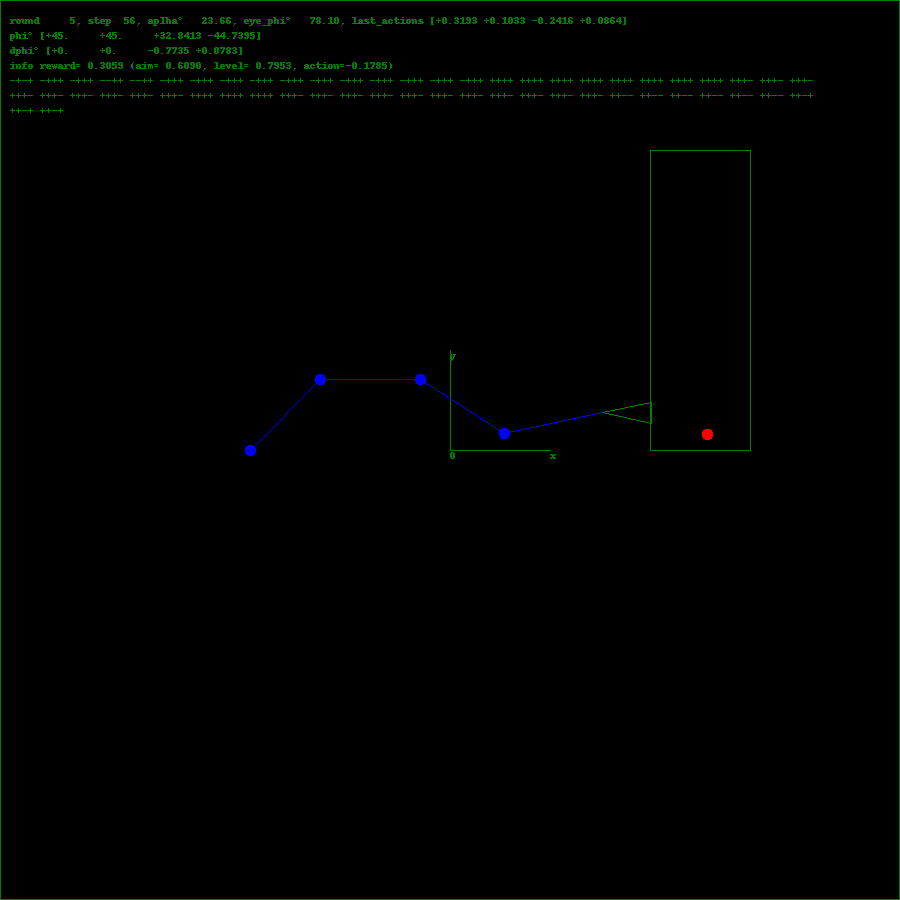

In [ ]:
for _ in range(5):
    run(N_JOINTS=4, N_SEGS=1, POLICY_CLASS=SAC, MODEL_NAME='MlpPolicy', N_ENVS=1)